In [1]:
pip install tensorflow transformers


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel


In [4]:

# Load your dataset
data = {
    "text": [
        " Hello, yourself. Enjoy London. Watch out for the Hackneys. They`re mental.",
        "Stupid liars. Glad they are ignorant, because I had a blast!!",
        " Where you at?   No tweeting today? No gardening either, I bet?",
        "if someone had`ve told me things would get this hard..i would never have done it",
        "My mind is playing tricks or me!...or could it be? Either way this ish is on my mind heavy and in sleepy",
        " Awesome.  I`m down in Ocean Beach (if you know where that is.) By the way. 'YourBiggestFan' I`m a re-al big fan of you-rs.",
        " I love to! But I`m only available from 5pm.  and where dear? Would love to help  convert her vids.Ã¯Â¿Â½",
        "Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job.  Can`t wait to have a dragon pet",
        "2am feedings for the baby are fun when he is all smiles and coos",
        "Both of you",
        "I'd have responded, if I were going",
        "Sooo SAD I will miss you here in San Diego!!!",
        "my boss is bullying me...",
        "what interview! leave me alone",
        "hm... Both of us I guess...",
        "romance zero is funny",
        "Sons of ****, why couldn't they put them on the releases we already bought",
        "I really really like the song Love Story by Taylor Swift",
        "the free fillin` app on my ipod is fun, im addicted"
    ],
    "sentiment": [
        "negative","negative","neutral","positive","neutral","positive","positive","positive","positive","neutral", "neutral", "negative", "negative", "negative",
        "neutral", "positive", "negative", "positive", "positive"
    ]
}
df = pd.DataFrame(data)

In [5]:
# Preprocess the sentiment labels
sentiment_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

In [6]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Tokenize the text data
def tokenize_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

tokenized_texts = tokenize_texts(df['text'])

In [8]:

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_texts),
    df['sentiment'].values
))

# Split into training and validation datasets
train_size = int(0.8 * len(df))
train_dataset = dataset.take(train_size).batch(16)
val_dataset = dataset.skip(train_size).batch(16)

In [9]:
def build_model():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    bert_output = bert_model([input_ids, attention_mask])
    cls_token = bert_output.last_hidden_state[:, 0, :]
    output = tf.keras.layers.Dense(3, activation='softmax')(cls_token)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [15]:
import tensorflow as tf

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Check the train dataset
for data in train_dataset.take(1):
    print("Train dataset sample:", data)

# Check the validation dataset
for data in val_dataset.take(1):
    print("Validation dataset sample:", data)

# Train the model again
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Train dataset sample: ({'input_ids': <tf.Tensor: shape=(15, 128), dtype=int32, numpy=
array([[  101,  7592,  1010, ...,     0,     0,     0],
       [  101,  5236, 16374, ...,     0,     0,     0],
       [  101,  2073,  2017, ...,     0,     0,     0],
       ...,
       [  101,  2026,  5795, ...,     0,     0,     0],
       [  101,  2054,  4357, ...,     0,     0,     0],
       [  101, 20287,  1012, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(15, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(15, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0,

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 5s 5s/step - loss: 0.8683 - accuracy: 0.8000 - val_loss: 0.9279 - val_accuracy: 0.7500
Epoch 2/10


1/1 [==============================] - 6s 6s/step - loss: 0.7391 - accuracy: 0.8000 - val_loss: 0.9168 - val_accuracy: 0.7500
Epoch 3/10


1/1 [==============================] - 2s 2s/step - loss: 0.6563 - accuracy: 0.8667 - val_loss: 0.9449 - val_accuracy: 0.7500
Epoch 4/10


1/1 [==============================] - 2s 2s/step - loss: 0.4523 - accuracy: 1.0000 - val_loss: 0.9924 - val_accuracy: 0.5000
Epoch 5/10


1/1 [==============================] - 2s 2s/step - loss: 0.3079 - accuracy: 1.0000 - val_loss: 1.0442 - val_accuracy: 0.5000
Epoch 6/10


1/1 [==============================] - 2s 2s/step - loss: 0.1750 - accuracy: 1.0000 - val_loss: 1.0951 - val_accuracy: 0.5000
Epoch 7/10


1/1 [==============================] - 2s 2s/step - loss: 0.1323 - accuracy: 1.0000 - val_loss: 1.1552 - val_accuracy: 0.5000
Epoch 8/10


1/1 [==============================] - 3s 3s/step - loss: 0.0756 - accuracy: 1.0000 - val_loss: 1.1981 - val_accuracy: 0.5000
Epoch 9/10


1/1 [==============================] - 2s 2s/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 1.2221 - val_accuracy: 0.5000
Epoch 10/10


1/1 [==============================] - 2s 2s/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 1.2320 - val_accuracy: 0.5000


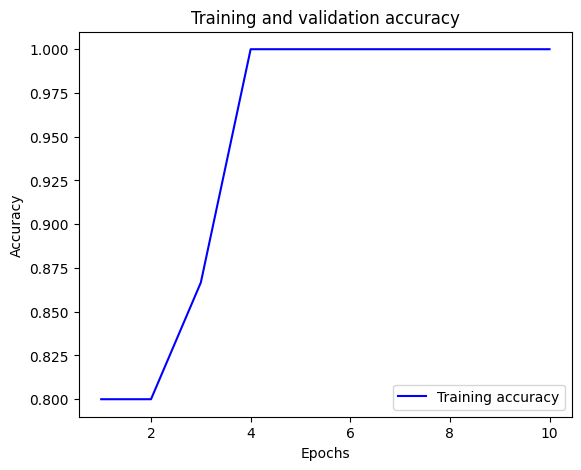

In [16]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extract metrics from history
    accuracy = history.history.get('accuracy')
    val_accuracy = history.history.get('val_accuracy')
    precision = history.history.get('precision')
    val_precision = history.history.get('val_precision')
    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    #plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot precision if it exists
    if precision and val_precision:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, precision, 'b', label='Training precision')
       # plt.plot(epochs, val_precision, 'r', label='Validation precision')
        plt.title('Training and validation precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    plt.show()

plot_metrics(history)


In [17]:
MODEL_DIR = "sentiment_model"
model.save(MODEL_DIR, save_format="tf")


In [18]:
# Load the model
custom_objects = {"TFBertModel": TFBertModel}
loaded_model = tf.keras.models.load_model(MODEL_DIR, custom_objects=custom_objects)


In [19]:
# Function to preprocess and tokenize new text input
def preprocess_text(text, max_len=128):
    tokenized_input = tokenizer(
        [text],
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return {
        "input_ids": tokenized_input["input_ids"],
        "attention_mask": tokenized_input["attention_mask"]
    }

In [20]:
# Function to predict sentiment from user input
def predict_sentiment(model, text):
    tokenized_input = preprocess_text(text)
    prediction = model.predict([tokenized_input['input_ids'], tokenized_input['attention_mask']])
    sentiment_index = np.argmax(prediction, axis=1)[0]

    sentiment_mapping = {0: 'neutral', 1: 'negative', 2: 'positive'}
    return sentiment_mapping[sentiment_index]


In [21]:
# Get dynamic user input and predict sentiment
while True:
    user_input = input("Enter a sentence to analyze sentiment (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break

    predicted_sentiment = predict_sentiment(loaded_model, user_input)
    print(f"The predicted sentiment for the input '{user_input}' is: {predicted_sentiment}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 285ms/step
The predicted sentiment for the input ' Hello, yourself. Enjoy London. Watch out for the Hackneys. They`re mental.' is: negative
1/1 [==============================] - 0s 357ms/step
The predicted sentiment for the input ' Where you at?   No tweeting today? No gardening either, I bet?' is: neutral
1/1 [==============================] - 0s 206ms/step
The predicted sentiment for the input 'the free fillin` app on my ipod is fun, im addicted' is: positive
1/1 [==============================] - 0s 209ms/step
The predicted sentiment for the input 'I really really like the song Love Story by Taylor Swift' is: negative
1/1 [==============================] - 0s 208ms/step
The predicted sentiment for the input 'Both of you' is: neutral
1/1 [==============================] - 0s 204ms/step
The predicted sentiment for the input 'I'd have responded, if I were going' is: neutral
1/1 [==============================] - 0s 214ms/step
The predicted sen

KeyboardInterrupt: Interrupted by user